In [4]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data_dir = "krylov_data3"
exact_file = "hubbard_exact_3.hdf5"
l = 3
output_filename = f"hubbard_{l}_error.pdf"
d_max = 30
d_min = 3

In [10]:
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [11]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = np.min(f_exact["energies"])
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is (1.0717967697244912+0j).


In [12]:
subspace_files = [f for f in all_files if "subspace" in f]
for i in range(len(subspace_files)):
    f_subspace = h5py.File(data_dir + "/" + subspace_files[i])
    ref_energy = f_subspace["reference_energy"][()]
    f_subspace.close()
    print(f"Reference energy = {ref_energy}")

Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)
Reference energy = (6.535898384862259+0j)


In [249]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact)
    df["steps"] = steps
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps
i                                                       
0    3  1.000000e-08 -4.588337        3  0.014482     60
1    4  1.000000e-08 -4.600704        4  0.002116     60
2    5  1.000000e-08 -4.601492        5  0.001327     60
3    6  1.000000e-08 -4.602057        6  0.000762     60
4    7  1.000000e-08 -4.602226        7  0.000594     60
..  ..           ...       ...      ...       ...    ...
28  31  1.000000e-08 -4.602793       20  0.000027    200
29  32  1.000000e-08 -4.602794       21  0.000026    200
30  33  1.000000e-08 -4.602795       21  0.000025    200
31  34  1.000000e-08 -4.602795       22  0.000024    200
32  35  1.000000e-08 -4.602796       22  0.000023    200

[363 rows x 6 columns]


In [250]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

     d           eps    energy  num_pos     error  steps
i                                                       
17  20  1.000000e-08 -4.602678       15  0.000141     60
18  21  1.000000e-08 -4.602687       15  0.000133     60
19  22  1.000000e-08 -4.602693       16  0.000126     60
20  23  1.000000e-08 -4.602700       16  0.000120     60
21  24  1.000000e-08 -4.602705       17  0.000114     60
..  ..           ...       ...      ...       ...    ...
28  31  1.000000e-08 -4.602793       20  0.000027    200
29  32  1.000000e-08 -4.602794       21  0.000026    200
30  33  1.000000e-08 -4.602795       21  0.000025    200
31  34  1.000000e-08 -4.602795       22  0.000024    200
32  35  1.000000e-08 -4.602796       22  0.000023    200

[176 rows x 6 columns]


In [251]:
df_inter = df_total[df_total["d"] <= d_max]
df_small = df_inter[df_inter["d"] >= d_min]
print(df_small.head())

   d           eps    energy  num_pos     error  steps
i                                                     
0  3  1.000000e-08 -4.588337        3  0.014482     60
1  4  1.000000e-08 -4.600704        4  0.002116     60
2  5  1.000000e-08 -4.601492        5  0.001327     60
3  6  1.000000e-08 -4.602057        6  0.000762     60
4  7  1.000000e-08 -4.602226        7  0.000594     60


In [252]:
chemical_accuracy = 0.00159 * l ** 2
print(f"Chemical accuracy is {chemical_accuracy} ha.")

Chemical accuracy is 0.02544 ha.


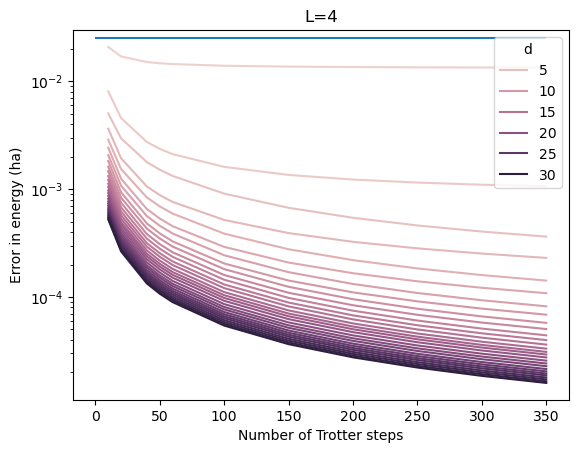

In [253]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.hlines(chemical_accuracy, 0, 350)
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
# plt.ylim(top=chemical_accuracy+ 0.01)
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Error in energy (ha)")
plt.title(f"L={l}")
plt.savefig(output_filename)

In [254]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [255]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.013424472086107642 0.02089482710680457
4 0.0010641772910195968 0.008080461052326626
5 0.0003632300677063327 0.005049986357144043
6 0.00023041774661258785 0.0036433388571062153
7 0.0001419610530923876 0.00287783688033727
8 0.00010846887197413224 0.0024237503967281526
9 8.194366546643295e-05 0.0020725083489612217
10 6.852062690843042e-05 0.0018273680385547664
11 5.753956654963588e-05 0.0016180562751451077
12 5.038762935694052e-05 0.0014664705253206733
13 4.4068551382281385e-05 0.00132279478991304
14 3.9811869601003025e-05 0.0012186279230368413
15 3.6166470013476726e-05 0.0011239162929079782
16 3.315449876595267e-05 0.0010482385211352252


In [256]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_4350/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.013424472086107642 and 0.02089482710680457